In [1]:
import glob
from prody import *
import pandas as pd
import re
import numpy as np
import tqdm
import natsort
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import py3Dmol
import networkx as nx

In [2]:
# Limits of p values:
# We do that because some p values can be reported to be zero.
np.finfo('float')

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

## Process data (only once)

In [11]:
BASE_FOLDER = '/mnt/MORIA/experiments/hla_b39/2022_10_14_bioe_leviathan_backup/T1DM_B39_traj_analysis/gmx_traj_data/'
grinn_outs = glob.glob(BASE_FOLDER+'*/grinn_output_skip10/energies_intEnVdW.csv')
dry_pdbs = glob.glob(BASE_FOLDER+'*/grinn_output_skip10/system_dry.pdb')

In [15]:
grinn_outs = [out for out in grinn_outs if 'B3801_ALL_2' not in out]

In [16]:
dry_pdbs = [pdb for pdb in dry_pdbs if 'B3801_ALL_2' not in pdb]

In [24]:
zipped = zip(dry_pdbs, grinn_outs)
df_list = list()
for zipd in list(zipped):
    dry_pdb = zipd[0]
    matches = re.search('.*(B.*)_(.+)_(\d+)/grinn_output_skip10/',dry_pdb)
    if matches:
        allele = matches.groups()[0]
        peptide = matches.groups()[1]
        replica = int(matches.groups()[2])
        print(pdb, peptide, replica)

    df_intEn = pd.read_csv(zipd[1])
    df_intEn['repeat'] = replica
    df_intEn['pdb'] = pdb
    df_intEn['dry_pdb_file'] = dry_pdb
    # Leave only certain rows in df_intEn since we messed up with trajectory frame concatenation. 
    # This does not affect analysis though it just adjusts which frames to read.
    if pdb == '3UTQ' and replica == 0:
        stride = stride_alt_2
    elif pdb == '3UTQ' and replica == 1:
        stride = stride_alt_1
    elif pdb == '3UTQ' and replica == 2:
        stride = stride_alt_1
    elif pdb == '5C0F':
        stride = stride_alt_2
    elif pdb == '5N1Y':
        stride = stride_alt_1
    elif pdb == 'pep_free':
        stride = stride_alt_3
    df_intEn = df_intEn[['Pair_indices','repeat','pdb','dry_pdb_file']]
    # Change column names from "Unnamed: 0" to "pair"
    df_intEn.rename({'Pair_indices': 'pair'}, axis=1, inplace=True)

    df_intEn = df_intEn[df_intEn.columns[:377]]
    

    df_list.append(df_intEn)

df_intEn = pd.concat(df_list)

B3906_ data/B3901 4
B3906_ ALL 4


B3906_ ALL 1
B3906_ ALL 2
B3906_ ALL 3
B3906_ ALL 4
B3906_ AL 1
B3906_ AL 2
B3906_ AL 3
B3906_ AL 4
B3906_ A 1
B3906_ A 2
B3906_ A 3
B3906_ A 4
B3906_ data/B3906 1
B3906_ data/B3906 2
B3906_ data/B3906 3
B3906_ data/B3906 4
B3906_ ALL 1
B3906_ ALL 2
B3906_ ALL 3
B3906_ data/B3801 1
B3906_ data/B3801 2
B3906_ data/B3801 3
B3906_ data/B3801 4
B3906_ ALL 1
B3906_ ALL 3
B3906_ ALL 4
B3906_ AL 1
B3906_ AL 2
B3906_ AL 3
B3906_ AL 4
B3906_ A 1
B3906_ A 2
B3906_ A 3
B3906_ A 4
B3906_ data/B3901 1
B3906_ data/B3901 2
B3906_ data/B3901 3
B3906_ AL 1
B3906_ AL 2
B3906_ AL 3
B3906_ AL 4
B3906_ A 1
B3906_ A 2
B3906_ A 3
B3906_ A 4


In [24]:
df_intEn.dropna(axis=1, inplace=True)

In [25]:
df_intEn.to_csv('intEnVdW_2024_09_24.csv')

## Process IE data

In [3]:
df_intEn = pd.read_csv('intEnVdW_2024_09_24.csv')

In [4]:
dry_pdb_file = ''

for row in tqdm.tqdm(df_intEn.iterrows()):
    pair = row[1]['pair']
    dry_pdb_file_row = row[1]['dry_pdb_file']
    if dry_pdb_file_row != dry_pdb_file:
        syst_dry = parsePDB(dry_pdb_file_row)
        dry_pdb_file = dry_pdb_file_row
    
    pairs = pair.split('-')
    pair1 = syst_dry.select(f'resindex {pairs[0]}')
    pair2 = syst_dry.select(f'resindex {pairs[1]}')
    resnum1 = pair1.getResnums()[0]
    resnum2 = pair2.getResnums()[0]
    chain1 = pair1.getChids()[0]
    chain2 = pair2.getChids()[0]
    df_intEn.loc[row[0],'resnum1'] = resnum1
    df_intEn.loc[row[0],'chain1'] = chain1
    df_intEn.loc[row[0],'resnum2'] = resnum2
    df_intEn.loc[row[0],'chain2'] = chain2
    resnum_chain1 = f'{resnum1}{chain1}'
    resnum_chain2 = f'{resnum2}{chain2}'
    resnum_chain12 = [resnum_chain1,resnum_chain2]
    resnum_chain12 = natsort.natsorted(resnum_chain12)
    resnum_chain12 = '-'.join(resnum_chain12)
    df_intEn.loc[row[0],'resnum_chain1'] = resnum_chain1
    df_intEn.loc[row[0],'resnum_chain2'] = resnum_chain2
    df_intEn.loc[row[0],'resnum_chain12'] = resnum_chain12

0it [00:00, ?it/s]@> 6130 atoms and 1 coordinate set(s) were parsed in 0.04s.
3050it [00:02, 1524.50it/s]@> 6130 atoms and 1 coordinate set(s) were parsed in 0.07s.
6298it [00:04, 1494.68it/s]@> 6130 atoms and 1 coordinate set(s) were parsed in 0.04s.
9389it [00:06, 1544.76it/s]@> 6165 atoms and 1 coordinate set(s) were parsed in 0.04s.
12620it [00:08, 1539.63it/s]@> 6165 atoms and 1 coordinate set(s) were parsed in 0.05s.
15705it [00:10, 1541.62it/s]@> 6165 atoms and 1 coordinate set(s) were parsed in 0.04s.
18824it [00:12, 1540.54it/s]@> 6177 atoms and 1 coordinate set(s) were parsed in 0.04s.
22060it [00:14, 1519.88it/s]@> 6177 atoms and 1 coordinate set(s) were parsed in 0.04s.
25260it [00:17, 1516.10it/s]@> 6177 atoms and 1 coordinate set(s) were parsed in 0.04s.
28551it [00:19, 1477.97it/s]@> 5997 atoms and 1 coordinate set(s) were parsed in 0.04s.
31567it [00:21, 1515.04it/s]@> 5997 atoms and 1 coordinate set(s) were parsed in 0.04s.
34573it [00:23, 1503.68it/s]@> 5997 atoms and

### Determine pairs that show consistent interactions in repeats.

In [15]:
uniq_pairs = df_intEn['resnum_chain12'].unique()

consistent_pairs = list()
other_pairs = list()

p_values_cons = list()
p_values_other = list()

for pair in tqdm.tqdm(uniq_pairs):
    df_intEn_pair = df_intEn[df_intEn['resnum_chain12']==pair].copy()

    resnum1 = df_intEn_pair['resnum1'].unique()[0]
    resnum2 = df_intEn_pair['resnum2'].unique()[0]
    chain1 = df_intEn_pair['chain1'].unique()[0]
    chain2 = df_intEn_pair['chain2'].unique()[0]

    if chain1 == chain2 and np.abs(resnum1-resnum2) < 4:
        # Don't take pairs that are too close along the covalently-bonded polypeptide chain into account.
        continue

    pdbs = df_intEn_pair['pdb'].unique()
    for pdb in pdbs:
        df_intEn_pair_system = df_intEn_pair[df_intEn_pair['pdb'] == pdb].copy()
        if len(df_intEn_pair_system) != 3:
            # Then we exclude this pair, it was not observed in at least one repeat.
            continue
        # Remove columns "Unnamed: 0", "pair","resnum1","chain1","resnum2","chain2"
        df_intEn_pair_system.drop(['Unnamed: 0','dry_pdb_file','pair','resnum1','chain1','resnum2','chain2',
                            'resnum_chain1','resnum_chain2','resnum_chain12','repeat','pdb'], axis=1, inplace=True)
        df_values = df_intEn_pair_system.T
        df_values.columns = [0,1,2]

        means = np.abs(list(map(np.mean,[df_values[0], df_values[1], df_values[2]])))
        if np.all(means > 0.8):
            
            f_statistic, p_value = scipy.stats.f_oneway(df_values[0], df_values[1], df_values[2])
            if p_value > 0.05:
                #print(f'Consistent pair: {pair} in {pdb} simulations with p-value {p_value}')
                #sns.kdeplot(df_values)
                #plt.title(f'Consistent pair: {pair} in {pdb} simulations with p-value {p_value}')
                #plt.show()
                consistent_pairs.append(pair)
                p_values_cons.append(p_value)
            else:
                other_pairs.append(pair)
                p_values_other.append(p_value)


100%|██████████| 4473/4473 [00:16<00:00, 273.92it/s]


In [16]:
df_cons_pairs = pd.DataFrame(consistent_pairs, columns=['resnum_chain12'])
df_cons_pairs['p_value'] = p_values_cons

In [17]:
df_other_pairs = pd.DataFrame(other_pairs, columns=['resnum_chain12'])
df_other_pairs['p_value'] = p_values_other

In [18]:
df_cons_pairs = pd.merge(df_intEn, df_cons_pairs, how='inner', on='resnum_chain12')
df_other_pairs = pd.merge(df_intEn, df_other_pairs, how='inner', on='resnum_chain12')

In [50]:
df_other_pairs

Unnamed: 0     pair  repeat       pdb  \
0              1    75-71       0      3UTQ   
1              5  315-325       0      3UTQ   
2             15  217-259       0      3UTQ   
3             15  217-259       0      3UTQ   
4             30  209-181       0      3UTQ   
...          ...      ...     ...       ...   
8137        3017  363-367       2  pep_free   
8138        3021  371-375       2  pep_free   
8139        3028  241-234       2  pep_free   
8140        3041  106-171       2  pep_free   
8141        3041  106-171       2  pep_free   

                                           dry_pdb_file         0        10  \
0      3UTQ/grinn_workflow_results_new_0/system_dry.pdb -1.321060  2.312460   
1      3UTQ/grinn_workflow_results_new_0/system_dry.pdb -2.134302 -2.033801   
2      3UTQ/grinn_workflow_results_new_0/system_dry.pdb -2.255832 -1.689886   
3      3UTQ/grinn_workflow_results_new_0/system_dry.pdb -2.255832 -1.689886   
4      3UTQ/grinn_workflow_results_new_0/system_dry.pdb -0.940711 -1.232982   
...                                                 ...       ...       ...   
8137  pep_free/grinn_workflow_results_new_2/system_d... -1.605738 -1.300929   
8138  pep_free/grinn_workflow_results_new_2/system_d... -0.263687 -0.276605   
8139  pep_free/grinn_workflow_results_new_2/system_d... -0.957937 -0.802496   
8140  pep_free/grinn_workflow_results_new_2/system_d... -3.294629 -2.517857   
8141  pep_free/grinn_workflow_results_new_2/system_d... -3.294629 -2.517857   

            20        30        40  ...       860       870  resnum1  chain1  \
0    -1.010852 -0.718424 -1.461408  ... -1.118334 -1.138747     76.0       A   
1    -1.705333 -1.082409 -1.716179  ... -1.795503 -1.297327     40.0       B   
2    -2.381589 -3.023604 -0.352472  ... -1.032120 -1.448642    218.0       A   
3    -2.381589 -3.023604 -0.352472  ... -1.032120 -1.448642    218.0       A   
4    -0.704221 -1.181601 -1.068946  ... -1.199654 -1.210177    210.0       A   
...        ...       ...       ...  ...       ...       ...      ...     ...   
8137 -1.585381 -1.698327 -0.783512  ... -1.746728 -2.528003     88.0       B   
8138 -0.835390 -3.017812 -2.798467  ... -2.136743 -1.951012     96.0       B   
8139 -0.508074 -0.799612 -0.828390  ... -0.823045 -1.321061    242.0       A   
8140 -3.032668 -3.833527 -2.807864  ... -2.885132 -3.671563    107.0       A   
8141 -3.032668 -3.833527 -2.807864  ... -2.885132 -3.671563    107.0       A   

      resnum2  chain2  resnum_chain1  resnum_chain2  resnum_chain12  \
0        72.0       A            76A            72A         72A-76A   
1        50.0       B            40B            50B         40B-50B   
2       260.0       A           218A           260A       218A-260A   
3       260.0       A           218A           260A       218A-260A   
4       182.0       A           210A           182A       182A-210A   
...       ...     ...            ...            ...             ...   
8137     92.0       B            88B            92B         88B-92B   
8138    100.0       B            96B           100B        96B-100B   
8139    235.0       A           242A           235A       235A-242A   
8140    172.0       A           107A           172A       107A-172A   
8141    172.0       A           107A           172A       107A-172A   

           p_value  
0     1.366928e-10  
1     1.484429e-03  
2     1.702264e-02  
3     1.071144e-02  
4     4.349441e-04  
...            ...  
8137  3.791471e-03  
8138  1.200782e-02  
8139  2.434191e-02  
8140  2.654906e-03  
8141  4.090298e-02  

[8142 rows x 101 columns]

In [20]:
df_cons_pairs

Unnamed: 0     pair  repeat       pdb  \
0               0  235-300       0      3UTQ   
1               5  315-325       0      3UTQ   
2               5  315-325       0      3UTQ   
3               5  315-325       0      3UTQ   
4              14  190-199       0      3UTQ   
...           ...      ...     ...       ...   
17495        3033  361-308       2  pep_free   
17496        3033  361-308       2  pep_free   
17497        3033  361-308       2  pep_free   
17498        3037  184-207       2  pep_free   
17499        3037  184-207       2  pep_free   

                                            dry_pdb_file         0        10  \
0       3UTQ/grinn_workflow_results_new_0/system_dry.pdb -0.889962  1.792924   
1       3UTQ/grinn_workflow_results_new_0/system_dry.pdb -2.134302 -2.033801   
2       3UTQ/grinn_workflow_results_new_0/system_dry.pdb -2.134302 -2.033801   
3       3UTQ/grinn_workflow_results_new_0/system_dry.pdb -2.134302 -2.033801   
4       3UTQ/grinn_workflow_results_new_0/system_dry.pdb -1.281373 -1.426724   
...                                                  ...       ...       ...   
17495  pep_free/grinn_workflow_results_new_2/system_d... -0.758289 -0.831022   
17496  pep_free/grinn_workflow_results_new_2/system_d... -0.758289 -0.831022   
17497  pep_free/grinn_workflow_results_new_2/system_d... -0.758289 -0.831022   
17498  pep_free/grinn_workflow_results_new_2/system_d... -1.346994 -1.808197   
17499  pep_free/grinn_workflow_results_new_2/system_d... -1.346994 -1.808197   

             20        30        40  ...       860       870  resnum1  chain1  \
0     -1.549491 -1.379467 -0.324026  ... -0.756509 -1.073477    236.0       A   
1     -1.705333 -1.082409 -1.716179  ... -1.795503 -1.297327     40.0       B   
2     -1.705333 -1.082409 -1.716179  ... -1.795503 -1.297327     40.0       B   
3     -1.705333 -1.082409 -1.716179  ... -1.795503 -1.297327     40.0       B   
4     -1.405040 -1.387548 -1.110137  ... -1.175555 -1.361822    191.0       A   
...         ...       ...       ...  ...       ...       ...      ...     ...   
17495 -0.953441 -0.874560 -1.315431  ... -0.826739 -1.040682     86.0       B   
17496 -0.953441 -0.874560 -1.315431  ... -0.826739 -1.040682     86.0       B   
17497 -0.953441 -0.874560 -1.315431  ... -0.826739 -1.040682     86.0       B   
17498 -2.263112 -2.228344 -2.268408  ... -2.217988 -2.171433    185.0       A   
17499 -2.263112 -2.228344 -2.268408  ... -2.217988 -2.171433    185.0       A   

       resnum2  chain2  resnum_chain1  resnum_chain2  resnum_chain12   p_value  
0         25.0       B           236A            25B        25B-236A  0.560991  
1         50.0       B            40B            50B         40B-50B  0.299853  
2         50.0       B            40B            50B         40B-50B  0.542850  
3         50.0       B            40B            50B         40B-50B  0.859772  
4        200.0       A           191A           200A       191A-200A  0.915120  
...        ...     ...            ...            ...             ...       ...  
17495     33.0       B            86B            33B         33B-86B  0.329367  
17496     33.0       B            86B            33B         33B-86B  0.664821  
17497     33.0       B            86B            33B         33B-86B  0.949781  
17498    208.0       A           185A           208A       185A-208A  0.257383  
17499    208.0       A           185A           208A       185A-208A  0.330915  

[17500 rows x 101 columns]

In [52]:
cols2_save = ['repeat','pdb','resnum_chain12','p_value'] + intEn_cols
df_cons_pairs[cols2_save].to_csv('df_cons_pairs_saved_2025_02_01.csv', index=False)

In [31]:
intEn_cols = list(map(str,np.arange(0,880,10)))

<Axes: ylabel='Density'>

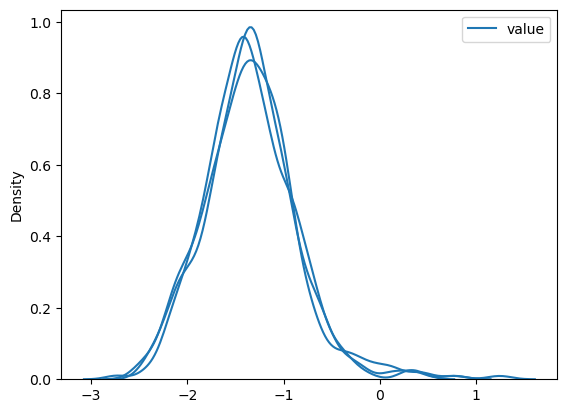

In [49]:
sns.kdeplot(pd.melt(df_cons_pairs[(df_cons_pairs['resnum_chain12'] == '40B-50B') & (df_cons_pairs['repeat'] == 0)][intEn_cols]))
sns.kdeplot(pd.melt(df_cons_pairs[(df_cons_pairs['resnum_chain12'] == '40B-50B') & (df_cons_pairs['repeat'] == 1)][intEn_cols]))
sns.kdeplot(pd.melt(df_cons_pairs[(df_cons_pairs['resnum_chain12'] == '40B-50B') & (df_cons_pairs['repeat'] == 2)][intEn_cols]))

<Axes: ylabel='Density'>

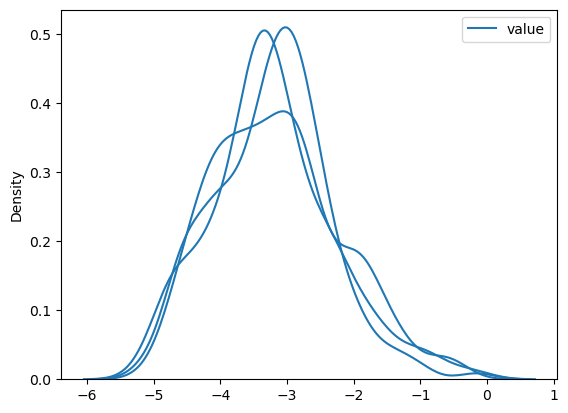

In [51]:
sns.kdeplot(pd.melt(df_other_pairs[(df_other_pairs['resnum_chain12'] == '107A-172A') & (df_other_pairs['repeat'] == 0)][intEn_cols]))
sns.kdeplot(pd.melt(df_other_pairs[(df_other_pairs['resnum_chain12'] == '107A-172A') & (df_other_pairs['repeat'] == 1)][intEn_cols]))
sns.kdeplot(pd.melt(df_other_pairs[(df_other_pairs['resnum_chain12'] == '107A-172A') & (df_other_pairs['repeat'] == 2)][intEn_cols]))

### Determine significantly affected pairs (among all replicas)

In [53]:
pairs = df_cons_pairs['resnum_chain12'].unique()

lonely_consistent_pairs = dict()

sig_aff_pairs = list()

for pair in pairs:
    df_intEn_pair = df_cons_pairs[df_cons_pairs['resnum_chain12']==pair].copy()

    unique_pdbs = df_intEn_pair['pdb'].unique()

    if len(unique_pdbs) == 1:
        # Then this pair was consistently observed in only one simulation.
        # Add that to lonely_consistent_pairs, but don't do anything further in the loop.
        lonely_consistent_pairs[unique_pdbs[0]] = pair
        continue

    pairvals = dict()
    for pdb in unique_pdbs:
        df_pair_pdb = df_intEn_pair[df_intEn_pair['pdb']==pdb].copy()

        val_arrays = list()
        for row in df_pair_pdb.iterrows():
            val_arrays.append(np.array(row[1][intEn_cols]))

        val_arrays = np.hstack(val_arrays)

        pairvals[pdb] = val_arrays

    f_statistic, p_value = scipy.stats.f_oneway(*[v for v in pairvals.values()])
    if p_value < 0.05:
        #print(f'Significantly affected pair: {pair} with p-value {p_value}')
        sig_aff_pairs.append(pair)

In [ ]:
sig_aff_pairs = [el.split('-') for el in sig_aff_pairs]

df_sig_aff_pairs = pd.DataFrame(sig_aff_pairs, columns=['rc1','rc2'])
df_sig_aff_res = np.hstack([df_sig_aff_pairs['rc1'].values,df_sig_aff_pairs['rc2'].values])
df_sig_aff_res = pd.DataFrame(df_sig_aff_res, columns=['res'])
df_sig_aff_res.value_counts()[:50]

### Determine significantly affected pairs between *each* peptide-loaded system and peptide-free system.

In [ ]:
pairs = df_cons_pairs['resnum_chain12'].unique()

pairs_only_in_pmhc = list()

sig_aff_pairs_loaded = list()
p_values = list()

for pair in pairs:
    df_intEn_pair = df_cons_pairs[df_cons_pairs['resnum_chain12']==pair].copy()

    unique_pdbs = df_intEn_pair['pdb'].unique()

    if len(unique_pdbs) == 1:
        # Then this pair was consistently observed in only one simulation.
        # We're not interested in this.
        continue

    if 'pep_free' not in unique_pdbs:
        # Then this pair was consistently observed in only one or more peptide-loaded simulation.
        # We register this in a separate list.
        for pdb in unique_pdbs:
            pairs_only_in_pmhc.append([pdb,pair])

        continue

    pairvals = dict()
    for pdb in [pdb for pdb in unique_pdbs if pdb != 'pep_free']:
        df_pair_pdb = df_intEn_pair[df_intEn_pair['pdb']==pdb].copy()
        df_pair_pep_free = df_intEn_pair[df_intEn_pair['pdb']=='pep_free'].copy()

        val_arrays_pdb = list()
        val_arrays_pep_free = list()

        for row in df_pair_pdb.iterrows():
            val_arrays_pdb.append(np.array(row[1][intEn_cols]))

        val_arrays_pdb = np.hstack(val_arrays_pdb)

        for row in df_pair_pep_free.iterrows():
            val_arrays_pep_free.append(np.array(row[1][intEn_cols]))

        val_arrays_pep_free = np.hstack(val_arrays_pep_free)

        pairvals[pdb] = val_arrays_pdb.astype('float')
        pairvals['pep_free'] = val_arrays_pep_free.astype('float')

        mean_diff = np.mean(pairvals[pdb]) - np.mean(pairvals['pep_free'])
        if np.abs(mean_diff) < 2:
            # This the difference is magnitude-wise insignificant. 
            # We're not interested in this.
            continue

        if mean_diff < 0:
            change_type = 'attractive'
        else:
            change_type = 'repulsive'

        t_statistic, p_value = scipy.stats.ttest_ind(pairvals[pdb], pairvals['pep_free'])
        if p_value < 0.05:
            #print(f'Significantly affected pair: {pair} with p-value {p_value}')
            sns.kdeplot(pairvals[pdb],color='blue')
            sns.kdeplot(pairvals['pep_free'],color='grey')
            plt.show()
            sig_aff_pairs_loaded.append([pdb,pair,change_type])
            p_values.append(p_value)

In [67]:
df_sig_aff_pairs_loaded = pd.DataFrame(sig_aff_pairs_loaded, columns=['pdb','pair','change_type'])
df_sig_aff_pairs_loaded['p_value'] = p_values

In [61]:
df_sig_aff_pairs_loaded.to_csv('df_sig_aff_pairs_loaded_2025_02_01.csv', index=False)

## Overall analysis

In [70]:
df_sig_aff_pairs_loaded = pd.read_csv('df_sig_aff_pairs_loaded_2025_02_01.csv')

In [71]:
print('How many pair interactions become more repulsive upon binding of ALWGPDPAAA (3UTQ)?')
print(len(df_sig_aff_pairs_loaded.query('pdb == "3UTQ" and change_type == "repulsive"')))
print('How many pair interactions become more attractive upon binding of ALWGPDPAAA (3UTQ)?')
print(len(df_sig_aff_pairs_loaded.query('pdb == "3UTQ" and change_type == "attractive"')))
print('----------------------------------------------------------')
print('How many pair interactions become more repulsive upon binding of RQWGPDPAAV (5C0F)?')
print(len(df_sig_aff_pairs_loaded.query('pdb == "5C0F" and change_type == "repulsive"')))
print('How many pair interactions become more attractive upon binding of RQWGPDPAAV (5C0F)?')
print(len(df_sig_aff_pairs_loaded.query('pdb == "5C0F" and change_type == "attractive"')))
print('----------------------------------------------------------')
print('How many pair interactions become more repulsive upon binding of RQFGPDWIVA (5N1Y)?')
print(len(df_sig_aff_pairs_loaded.query('pdb == "5N1Y" and change_type == "repulsive"')))
print('How many pair interactions become more attractive upon binding of RQFGPDWIVA (5N1Y)?')
print(len(df_sig_aff_pairs_loaded.query('pdb == "5N1Y" and change_type == "attractive"')))

How many pair interactions become more repulsive upon binding of ALWGPDPAAA (3UTQ)?
11
How many pair interactions become more attractive upon binding of ALWGPDPAAA (3UTQ)?
6
----------------------------------------------------------
How many pair interactions become more repulsive upon binding of RQWGPDPAAV (5C0F)?
22
How many pair interactions become more attractive upon binding of RQWGPDPAAV (5C0F)?
25
----------------------------------------------------------
How many pair interactions become more repulsive upon binding of RQFGPDWIVA (5N1Y)?
23
How many pair interactions become more attractive upon binding of RQFGPDWIVA (5N1Y)?
23


In [56]:
def create_string_for_protein_imaging(df_input):
    uniq_pairs = dict()
    pairs = df_input.pair.unique()
    pairs = [pair.split('-') for pair in pairs]
    for pair in pairs:
        pair1 = pair[0][:-1]
        chain1 = pair[0][-1]
        if chain1 not in uniq_pairs:
            uniq_pairs[chain1] = list()
            
        uniq_pairs[chain1].append(pair1)

        pair2 = pair[1][:-1]
        chain2 = pair[1][-1]

        if chain2 not in uniq_pairs:
            uniq_pairs[chain2] = list()
            
        uniq_pairs[chain2].append(pair2)

    for ch in uniq_pairs:
        print(f'chain {ch}')
        print(' '.join(np.unique(uniq_pairs[ch])))

In [57]:
df_sig_aff_pairs_loaded.query('pdb == "3UTQ" and change_type == "attractive"')

pdb      pair change_type
11   3UTQ  29A-209A  attractive
28   3UTQ  29A-103A  attractive
38   3UTQ    5A-33A  attractive
72   3UTQ   10A-22A  attractive
73   3UTQ   4A-168A  attractive
104  3UTQ    5A-99A  attractive

In [58]:
create_string_for_protein_imaging(df_sig_aff_pairs_loaded.query('pdb == "3UTQ" and change_type == "attractive"'))

chain A
10 103 168 209 22 29 33 4 5 99


In [59]:
df_sig_aff_pairs_loaded.query('pdb == "3UTQ" and change_type == "repulsive"')

pdb     pair change_type
2    3UTQ   7A-98A   repulsive
20   3UTQ  12A-20A   repulsive
22   3UTQ  5A-102A   repulsive
25   3UTQ  12A-34B   repulsive
27   3UTQ  7A-159A   repulsive
58   3UTQ   7A-97A   repulsive
66   3UTQ   7A-33A   repulsive
76   3UTQ  15A-89A   repulsive
86   3UTQ  3A-172A   repulsive
90   3UTQ  23A-63B   repulsive
105  3UTQ  12A-21A   repulsive

In [60]:
create_string_for_protein_imaging(df_sig_aff_pairs_loaded.query('pdb == "3UTQ" and change_type == "repulsive"'))

chain A
102 12 15 159 172 20 21 23 3 33 5 7 89 97 98
chain B
34 63


In [61]:
df_sig_aff_pairs_loaded.query('pdb == "5C0F" and change_type == "attractive"')

pdb       pair change_type
0    5C0F  182A-210A  attractive
8    5C0F  220A-258A  attractive
12   5C0F  215A-263A  attractive
16   5C0F    83A-88A  attractive
18   5C0F  100A-115A  attractive
23   5C0F    24A-38A  attractive
30   5C0F  220A-257A  attractive
32   5C0F    11A-23A  attractive
34   5C0F    2A-107A  attractive
36   5C0F     8A-25A  attractive
40   5C0F     7A-27A  attractive
45   5C0F  205A-245A  attractive
47   5C0F    2A-106A  attractive
52   5C0F    37A-46A  attractive
54   5C0F  127A-134A  attractive
64   5C0F    8A-100A  attractive
83   5C0F     9A-57B  attractive
87   5C0F     9A-26A  attractive
91   5C0F  124A-141A  attractive
93   5C0F     7A-28A  attractive
96   5C0F    28A-33A  attractive
98   5C0F   11B-235A  attractive
100  5C0F    60A-64A  attractive
102  5C0F    79A-83A  attractive
108  5C0F    11A-55B  attractive

In [62]:
create_string_for_protein_imaging(df_sig_aff_pairs_loaded.query('pdb == "5C0F" and change_type == "attractive"'))

chain A
100 106 107 11 115 124 127 134 141 182 2 205 210 215 220 23 235 24 245 25 257 258 26 263 27 28 33 37 38 46 60 64 7 79 8 83 88 9
chain B
11 55 57


In [63]:
df_sig_aff_pairs_loaded.query('pdb == "5C0F" and change_type == "repulsive"')

pdb       pair change_type
3    5C0F  126A-133A   repulsive
6    5C0F  213A-263A   repulsive
14   5C0F  204A-244A   repulsive
21   5C0F    12A-20A   repulsive
26   5C0F    12A-34B   repulsive
39   5C0F     6A-28A   repulsive
42   5C0F    22A-38A   repulsive
48   5C0F    1A-210A   repulsive
50   5C0F  206A-242A   repulsive
56   5C0F    27A-32A   repulsive
59   5C0F  159A-163A   repulsive
61   5C0F    45A-63A   repulsive
63   5C0F     5A-28A   repulsive
67   5C0F  167A-171A   repulsive
69   5C0F  231A-244A   repulsive
74   5C0F  188A-204A   repulsive
77   5C0F    10A-56B   repulsive
79   5C0F    61B-96A   repulsive
81   5C0F  100A-113A   repulsive
84   5C0F    59A-63A   repulsive
103  5C0F    25A-56B   repulsive
106  5C0F    12A-21A   repulsive

In [64]:
create_string_for_protein_imaging(df_sig_aff_pairs_loaded.query('pdb == "5C0F" and change_type == "repulsive"'))

chain A
1 10 100 113 12 126 133 159 163 167 171 188 20 204 206 21 210 213 22 231 242 244 25 263 27 28 32 38 45 5 59 6 63 96
chain B
34 56 61


In [49]:
df_sig_aff_pairs_loaded.query('pdb == "5N1Y" and change_type == "attractive"')

pdb       pair change_type
1    5N1Y  182A-210A  attractive
9    5N1Y  220A-258A  attractive
13   5N1Y  215A-263A  attractive
17   5N1Y    83A-88A  attractive
19   5N1Y  100A-115A  attractive
24   5N1Y    24A-38A  attractive
31   5N1Y  220A-257A  attractive
33   5N1Y    11A-23A  attractive
35   5N1Y    2A-107A  attractive
37   5N1Y     8A-25A  attractive
41   5N1Y     7A-27A  attractive
44   5N1Y     5A-29A  attractive
46   5N1Y  205A-245A  attractive
53   5N1Y    37A-46A  attractive
55   5N1Y  127A-134A  attractive
88   5N1Y     9A-26A  attractive
92   5N1Y  124A-141A  attractive
95   5N1Y  117A-125A  attractive
97   5N1Y    28A-33A  attractive
99   5N1Y   11B-235A  attractive
101  5N1Y    60A-64A  attractive
107  5N1Y     3A-30A  attractive
109  5N1Y    11A-55B  attractive

In [65]:
create_string_for_protein_imaging(df_sig_aff_pairs_loaded.query('pdb == "5N1Y" and change_type == "attractive"'))

chain A
100 107 11 115 117 124 125 127 134 141 182 2 205 210 215 220 23 235 24 245 25 257 258 26 263 27 28 29 3 30 33 37 38 46 5 60 64 7 8 83 88 9
chain B
11 55


In [66]:
df_sig_aff_pairs_loaded.query('pdb == "5N1Y" and change_type == "repulsive"')

pdb       pair change_type
4   5N1Y  126A-133A   repulsive
5   5N1Y  114A-126A   repulsive
7   5N1Y  213A-263A   repulsive
10  5N1Y    2A-104A   repulsive
15  5N1Y  204A-244A   repulsive
29  5N1Y    4A-104A   repulsive
43  5N1Y    22A-38A   repulsive
49  5N1Y    1A-210A   repulsive
51  5N1Y  206A-242A   repulsive
57  5N1Y    27A-32A   repulsive
60  5N1Y  159A-163A   repulsive
62  5N1Y    45A-63A   repulsive
65  5N1Y    8A-100A   repulsive
68  5N1Y  167A-171A   repulsive
70  5N1Y  231A-244A   repulsive
71  5N1Y     8A-98A   repulsive
75  5N1Y  188A-204A   repulsive
78  5N1Y    10A-56B   repulsive
80  5N1Y    61B-96A   repulsive
82  5N1Y  100A-113A   repulsive
85  5N1Y    59A-63A   repulsive
89  5N1Y     7A-99A   repulsive
94  5N1Y    6A-100A   repulsive

In [68]:
create_string_for_protein_imaging(df_sig_aff_pairs_loaded.query('pdb == "5N1Y" and change_type == "repulsive"'))

chain A
1 10 100 104 113 114 126 133 159 163 167 171 188 2 204 206 210 213 22 231 242 244 263 27 32 38 4 45 59 6 63 7 8 96 98 99
chain B
56 61


Visualize pairs that became more repulsive and attractive

In [17]:
def vis_pairs(pdb_file, df_tovis, pair_color='red'):
    pdb_str = open(pdb_file, 'r').read()
    # Initialize viewer
    view = py3Dmol.view(width=800, height=600)

    # Add model from the PDB string
    view.addModel(pdb_str, 'pdb')

    # Apply cartoon representation for the entire protein
    view.setStyle({'cartoon': {}})

    for pair in df_tovis['pair'].unique():
        res1 = pair.split('-')[0]
        res2 = pair.split('-')[1]
        # Highlight residues 182-210 in chain A with Van der Waals (VDW) representation
        view.setStyle({'chain':res1[-1], 'resi':res1[:-1]}, {'sphere': {'radius': 1.0, 'color': pair_color}})
        view.setStyle({'chain':res2[-1], 'resi':res2[:-1]}, {'sphere': {'radius': 1.0, 'color': pair_color}})

    # Zoom to the selected residues
    view.zoomTo()

    # Show the viewer
    view.show()

In [19]:
# Load your PDB structure as a string
vis_pairs('3UTQ/npt_dry_chid_added.pdb',
          df_sig_aff_pairs_loaded.query("pdb == '3UTQ' and change_type == 'attractive'").copy(),
          'red')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [23]:
# Load your PDB structure as a string
vis_pairs('3UTQ/npt_dry_chid_added.pdb',
          df_sig_aff_pairs_loaded.query("pdb == '3UTQ' and change_type == 'repulsive'").copy(),
          'blue')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [21]:
# Load your PDB structure as a string
vis_pairs('5N1Y/npt_dry_chid_added.pdb',
          df_sig_aff_pairs_loaded.query("pdb == '5N1Y' and change_type == 'attractive'").copy(),
          'red')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [25]:
# Load your PDB structure as a string
vis_pairs('5N1Y/npt_dry_chid_added.pdb',
          df_sig_aff_pairs_loaded.query("pdb == '5N1Y' and change_type == 'repulsive'").copy(),
          'blue')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [22]:
# Load your PDB structure as a string
vis_pairs('5C0F/npt_dry_chid_added.pdb',
          df_sig_aff_pairs_loaded.query("pdb == '5C0F' and change_type == 'attractive'").copy(),
          'red')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [26]:
# Load your PDB structure as a string
vis_pairs('5C0F/npt_dry_chid_added.pdb',
          df_sig_aff_pairs_loaded.query("pdb == '5C0F' and change_type == 'repulsive'").copy(),
          'blue')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Create Protein Energy Networks and Analysis Results (only once)

In [4]:
df_intEn = pd.read_csv('intEnVdW_2024_09_24.csv')

In [110]:
def getRibeiroOrtizNetwork(pdb, df_intEn, includeCovalents=True,intEnCutoff=1,rmsdEn=5, startFrame=0):
	# Get the number of residues
	sys = parsePDB(pdb)
	sys_sel1 = sys.select("name CA")
	sys_sel2 = sys.select("name CA")
	numResidues_sel1 = len(np.unique(sys_sel1.getResindices()))
	numResidues_sel2 = len(np.unique(sys_sel2.getResindices()))

	# Get the system that includes both selections
	sys_sels = sys.select("name CA")
	resIndices_sels = np.unique(sys_sels.getResindices())
	numResidues = len(resIndices_sels)
	resIndices_sels_sel_str = ' '.join(list(map(str,resIndices_sels)))

	resNames = sys_sels.getResnames()
	resNums = sys_sels.getResnums()
	chains = sys_sels.getChids()

	# NOPE; THIS GET UNIQS APPROACH IS NOT WORKING. WE SHALL DO CA BASED LISTING!
	# WHY DID I NOT THINK ABOUT THIS BEFORE???
	def get_uniqs(original_list):
		
		result_list = list()
		seen = set()
		
		for item in original_list:
			if item not in seen:
				result_list.append(item)  # Add the first occurrence
				seen.add(item)
			elif item != result_list[-1]:
				result_list.append(item)  # Add subsequent occurrences of the last unique item

		return result_list

	rname_rnum_ch = zip(list(map(str,resNames)),list(map(str,resNums)),chains)
	rname_rnum_ch = ['_'.join(el) for el in rname_rnum_ch]
	#rname_rnum_ch = list(get_uniqs(rname_rnum_ch))

	# Get number of frames in df_intEn
	numFrames = len(df_intEn.columns[1:])
	# Start a list to store networks
	nx_list = list()
	
	for m in tqdm.tqdm(range(startFrame,numFrames)):

		frame_col = df_intEn.columns[1+m]
		# Create the network, and add nodes representing all residues in the protein
		network = nx.Graph()

		for j in range(0,numResidues):
			#print('adding: ',j+1,rname_rnum_ch[j])
			network.add_node(j+1, label=rname_rnum_ch[j])

		# Create an average residue interaction matrix for this specific frame.
		resIntEnMat = np.zeros((numResidues,numResidues))

		for row in df_intEn.iterrows():
			pair = row[1]['pair']
			resindex_1 = int(pair.split('-')[0])
			resindex_2 = int(pair.split('-')[1])
			resIntEnMat[resindex_1,resindex_2] = row[1][frame_col]
			resIntEnMat[resindex_2,resindex_1] = row[1][frame_col]

		# Determine RMSD of interaction energies (needed later on)
		#resIntEnArray = [i for i in np.reshape(resIntEnMat,(1,numResidues**2))[0]]
		#rmsdIntEn = np.sqrt(np.mean((resIntEnArray - np.mean(resIntEnArray)) ** 2))

		# Construct an matrix to make edge weights later on according to Ribeiro et al. (2014)
		#X = 0.5*(1-(resIntEnMat-np.mean(resIntEnArray))/(5*rmsdIntEn))

		# Construct an edge weights matrix.
		resIntEnMatNegFavor = np.zeros(np.shape(resIntEnMat))
		for i in range(0,np.shape(resIntEnMat)[0]):
			for j in range(0,np.shape(resIntEnMat)[0]):
				if resIntEnMat[i,j] < 0:
					resIntEnMatNegFavor[i,j] = np.abs(resIntEnMat[i,j])
				else:
					resIntEnMatNegFavor[i,j] = 0

		X = np.abs(resIntEnMatNegFavor)/np.max(np.abs(resIntEnMatNegFavor))

		for i in range(0,numResidues_sel1):
			for j in range(0,numResidues_sel2):

				if X[i,j] > 0.99:
					X[i,j] = 0.99

				if X[i,j] < 0:
					X[i,j] = 0
					print('alert: negative weight, reassigning to zero.')

		# If covalent bonds are also requested, then
		# Connect covalently bound residues with edge weight of 0.99 and an edge distance of 1/weight.
		if includeCovalents:
			for i in range(0,numResidues-1):
				resindex1 = resIndices_sels[i]
				resindex2 = resIndices_sels[i+1]
				res1 = sys.select('resindex %i' % resindex1)
				res2 = sys.select('resindex %i' % resindex2)
			
				# Only connect if the two residues are in the same chain
				# Weights as is
				if (res1.getChids()[0] == res2.getChids()[0]) and (res1.getSegindices()[0] == res2.getSegindices()[1]):
					network.add_edge(i+1,i+2,weight=X[i,i+1],distance=1-float(X[i,i+1]))


				# Weights with -log
				#if (res1.getChids()[0] == res2.getChids()[0]) and (res1.getSegindices()[0] == res2.getSegindices()[1]):
				#	network.add_edge(i+1,i+2,{'distance':-np.log(0.99)})

		for i in range(0,numResidues_sel1):
			for j in range(0,numResidues_sel2):

				if not includeCovalents:
				# Check again for covalent connection. If we are iterating over a residue pair covalently connected, then skip
					if abs(i-j) == 1:
						continue

			# Check whether edges exist between these residues.
				if not network.has_edge(i+1,j+1):

					# Check whether the mean interaction energy between the two residues is above the cutoff value.
					# If yes, continue.
					if abs(float(resIntEnMat[i,j])) >= float(abs(intEnCutoff)):

						# Add an edge between the two residues. Specify distance according to Ribeiro et al. (2014)
						# Also, consider edge weights lower than 0.01 disconnected
						# (again, Ribeiro et al. 2014)
						if X[i,j] < 0.01:
							continue

						# Connect the two residues with edge weight as calculated above and an edge distance of 1/weight.
						# weights as is
						network.add_edge(i+1,j+1,weight=X[i,j],distance=1-float(X[i,j]))
						# weights as -log
						#network.add_edge(i+1,j+1,{'distance':-np.log(X[i,j])})

		nx_list.append(network)

	return nx_list

In [111]:
def getBCs(dry_pdb_file,df_2network):
    nx_list = getRibeiroOrtizNetwork(dry_pdb_file,df_2network)
    df_bcs = [pd.DataFrame(nx.betweenness_centrality(nx_list[i]).items(),columns=['Residue','BC']) for i in range(0,len(nx_list))]
    i = 0
    for df in df_bcs:
        df['Frame'] = i
        nw = nx_list[i]
        node_labels = [nw.nodes[j]['label'] for j in df['Residue'].values]
        df['Label'] = node_labels
        i += 1
    df_bc = pd.concat(df_bcs,axis=0)
    return nx_list, df_bc

In [112]:
pdb_codes = df_intEn.pdb.unique()
numRepeats = 3

In [113]:
df_bc_list = list()
intEn_cols = list(map(str,np.arange(0,880,10)))
for pdb in pdb_codes:
    for i in range(0,numRepeats):
        df_2network = df_intEn.query(f"pdb == '{pdb}' & repeat == {i}")
        dry_pdb_file = df_2network['dry_pdb_file'].values[0]
        nx_list,df = getBCs(dry_pdb_file, df_2network[['pair']+intEn_cols])
        df['pdb'] = pdb
        df['repeat'] = i
        df_bc_list.append(df)

df_bc = pd.concat(df_bc_list,axis=0,ignore_index=True)

100%|██████████| 88/88 [00:16<00:00,  5.29it/s]


In [115]:
df_bc['Residue_id'] = df_bc['Label'].str[4:]

In [126]:
df_bc_equil = df_bc.query('Frame > 20')

In [163]:
df_bc_equil.to_csv('df_bc_equil_2025_02_01.csv',index=False)

## Analysis of PEN - Betweenness Centralities (only once)

In [5]:
df_bc_equil = pd.read_csv('df_bc_equil_2025_02_01.csv')

In [6]:
df_bc_equil.head()

Residue        BC  Frame    Label   pdb  repeat Residue_id
0        1  0.000000     21  GLY_1_A  3UTQ       0        1_A
1        2  0.005195     21  SER_2_A  3UTQ       0        2_A
2        3  0.010363     21  HIS_3_A  3UTQ       0        3_A
3        4  0.018078     21  SER_4_A  3UTQ       0        4_A
4        5  0.041594     21  MET_5_A  3UTQ       0        5_A

In [8]:
pdb_codes = df_bc_equil.pdb.unique()
numRepeats = 3

In [9]:
cons_resids_pdbs = list()
p_values = list()
for pdb in pdb_codes:
    df_bc_eq_pdb = df_bc_equil.query(f"pdb == '{pdb}'")

    resids = df_bc_eq_pdb.Residue_id.unique()

    for res in tqdm.tqdm(resids):
        df_res = df_bc_eq_pdb.query(f"Residue_id == '{res}'")

        bc_1 = df_res.query('repeat == 0')['BC'].values
        bc_2 = df_res.query('repeat == 1')['BC'].values
        bc_3 = df_res.query('repeat == 2')['BC'].values
        f_statistic, p_value = scipy.stats.f_oneway(bc_1, bc_2, bc_3)
        if p_value > 0.05:
            cons_resids_pdbs.append([res,pdb])
            p_values.append(p_value)
            #print(f"Consistent residue: {lbl} in {pdb} simulations!")

  0%|          | 0/386 [00:00<?, ?it/s]

100%|██████████| 376/376 [00:01<00:00, 200.69it/s]


In [10]:
df_cons_resids_pdbs = pd.DataFrame(cons_resids_pdbs,columns=['Residue_id','pdb'])
df_cons_resids_pdbs['p_value'] = p_values

In [14]:
df_bc_equil_cons_resids = pd.merge(df_bc_equil,df_cons_resids_pdbs,how='outer',on=['Residue_id','pdb'])

In [15]:
df_bc_equil_cons_resids.to_csv('df_bc_equil_cons_resids_2025_02_01.csv',index=False)

## Analysis of PEN - Betweenness Centralities - Significantly Affected Residues (only once)

In [16]:
df_bc_equil_cons_resids = pd.read_csv('df_bc_equil_cons_resids_2025_02_01.csv')

In [17]:
df_bc_equil_cons_resids.loc[df_bc_equil_cons_resids["pdb"] == '3UTQ','peptide'] = 'ALWGPDPAAA'
df_bc_equil_cons_resids.loc[df_bc_equil_cons_resids["pdb"] == '5C0F','peptide'] = 'RQWGPDPAAV'
df_bc_equil_cons_resids.loc[df_bc_equil_cons_resids["pdb"] == '5N1Y','peptide'] = 'MVWGPDPLYV'
df_bc_equil_cons_resids.loc[df_bc_equil_cons_resids["pdb"] == 'pep_free','peptide'] = 'no peptide'

In [152]:
sig_aff_resids = list()
for resid in df_cons_resids_pdbs['Residue_id'].unique():
    df_resid = df_bc_equil_cons_resids.query(f"Residue_id == '{resid}'")
    pdbs = df_resid.pdb.unique()

    if len(pdbs) == 1:
        continue
    
    bc_resid_pdbs = dict()
    median_bc_nopf = list()
    median_bc = list()
    for pdb in pdbs:
        df_resid_pdb = df_resid.query(f"pdb == '{pdb}'")
        bc_resid_pdb = df_resid_pdb['BC'].values
        median_bc_resid_pdb = np.median(bc_resid_pdb)
        bc_resid_pdbs[pdb] = bc_resid_pdb
        if pdb != 'pep_free':
            median_bc_nopf.append(median_bc_resid_pdb)

        median_bc.append(median_bc_resid_pdb)
    
    f_statistic, p_value = scipy.stats.f_oneway(*list(bc_resid_pdbs.values()))
    if p_value < 0.05:
        if 'pep_free' in bc_resid_pdbs:
            diff_bc_3utq_pf = np.median(bc_resid_pdbs['3UTQ']) - np.median(bc_resid_pdbs['pep_free'])
            pt_diff_bc_3utq_pf = diff_bc_3utq_pf/np.abs(np.median(bc_resid_pdbs['3UTQ']))
            diff_bc_5n1y_pf = np.median(bc_resid_pdbs['5N1Y']) - np.median(bc_resid_pdbs['pep_free'])
            pt_diff_bc_5n1y_pf = diff_bc_5n1y_pf/np.abs(np.median(bc_resid_pdbs['5N1Y']))
            diff_bc_5c0f_pf = np.median(bc_resid_pdbs['5C0F']) - np.median(bc_resid_pdbs['pep_free'])
            pt_diff_bc_5c0f_pf = diff_bc_5c0f_pf/np.abs(np.median(bc_resid_pdbs['5C0F']))
        else:
            diff_bc_3utq_pf = None
            diff_bc_5n1y_pf = None
            diff_bc_5c0f_pf = None
            pt_diff_bc_3utq_pf = None
            pt_diff_bc_5n1y_pf = None
            pt_diff_bc_5c0f_pf = None

        sig_aff_resids.append([resid, np.mean(median_bc_nopf), diff_bc_3utq_pf, diff_bc_5n1y_pf, diff_bc_5c0f_pf,
                               pt_diff_bc_3utq_pf, pt_diff_bc_5n1y_pf, pt_diff_bc_5c0f_pf,p_value])
        #print(f"Sig aff residue: {resid}")

/tmp/ipykernel_1754/1928031460.py:26: RuntimeWarning: invalid value encountered in scalar divide
  pt_diff_bc_3utq_pf = diff_bc_3utq_pf/np.abs(np.median(bc_resid_pdbs['3UTQ']))
/tmp/ipykernel_1754/1928031460.py:28: RuntimeWarning: invalid value encountered in scalar divide
  pt_diff_bc_5n1y_pf = diff_bc_5n1y_pf/np.abs(np.median(bc_resid_pdbs['5N1Y']))
/tmp/ipykernel_1754/1928031460.py:30: RuntimeWarning: invalid value encountered in scalar divide
  pt_diff_bc_5c0f_pf = diff_bc_5c0f_pf/np.abs(np.median(bc_resid_pdbs['5C0F']))
/tmp/ipykernel_1754/1928031460.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  pt_diff_bc_3utq_pf = diff_bc_3utq_pf/np.abs(np.median(bc_resid_pdbs['3UTQ']))
/tmp/ipykernel_1754/1928031460.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  pt_diff_bc_3utq_pf = diff_bc_3utq_pf/np.abs(np.median(bc_resid_pdbs['3UTQ']))
/tmp/ipykernel_1754/1928031460.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  pt_diff_bc_5n

In [154]:
df_bc_sig_aff_resids = pd.DataFrame(sig_aff_resids,columns=['Residue_id','mean_median_bc','diff_bc_3utq_pf','diff_bc_5n1y_pf','diff_bc_5c0f_pf',
                                                        'pt_diff_bc_3utq_pf', 'pt_diff_bc_5n1y_pf', 'pt_diff_bc_5c0f_pf','p_value'])

In [162]:
df_bc_sig_aff_resids.to_csv('df_bc_sigaff_resids_2025_02_01.csv',index=False)

## Analysis of PEN - Betweenness Centralities - Conservation and Differential Analysis 

In [19]:
df_bc_sig_aff_resids = pd.read_csv('df_bc_sigaff_resids_2025_02_01.csv')

In [24]:
df_bc_sig_aff_resids.sort_values(by='mean_median_bc', ascending=False, inplace=True)

In [37]:
df_bc_sig_aff_resids

Residue_id  mean_median_bc  diff_bc_3utq_pf  diff_bc_5n1y_pf  \
209       27_B        0.207644         0.006867         0.027669   
271       64_B        0.182151         0.043241         0.059742   
289      235_A        0.095692        -0.004055         0.103902   
60        65_B        0.093996        -0.010212        -0.008092   
79        11_B        0.092359        -0.002826         0.005453   
..         ...             ...              ...              ...   
160      276_A        0.000062         0.000000         0.000098   
144      268_A        0.000060        -0.000024        -0.000204   
153      129_A        0.000059        -0.000067        -0.000136   
154        1_A        0.000000         0.000000         0.000000   
291      277_A        0.000000              NaN              NaN   

     diff_bc_5c0f_pf  pt_diff_bc_3utq_pf  pt_diff_bc_5n1y_pf  \
209         0.004037            0.034051            0.124381   
271         0.022860            0.235720            0.298793   
289         0.121644           -0.227730            0.826167   
60         -0.007747           -0.110441           -0.085546   
79         -0.004490           -0.031344            0.055403   
..               ...                 ...                 ...   
160         0.000087                 NaN            1.000000   
144        -0.000204           -0.131253                -inf   
153        -0.000027           -0.987358                -inf   
154         0.000000                 NaN                 NaN   
291              NaN                 NaN                 NaN   

     pt_diff_bc_5c0f_pf        p_value  cons_score  
209            0.020305   2.649195e-09         NaN  
271            0.140190   6.132575e-32         NaN  
289            0.847658  2.249479e-139         NaN  
60            -0.081610   3.653714e-03         NaN  
79            -0.050737   2.953821e-04         NaN  
..                  ...            ...         ...  
160            1.000000   2.391631e-21         NaN  
144                -inf   3.479121e-13         NaN  
153           -0.250232   4.631175e-17         NaN  
154                 NaN   1.232863e-04         NaN  
291                 NaN   6.133356e-09         NaN  

[296 rows x 10 columns]

In [38]:
# Read 5N1Y_With_Conservation_Scores.pdb from the current directory
pdb_file = '5N1Y_With_Conservation_Scores.pdb'
pdb_str = open(pdb_file, 'r').read()

# Start an emptry dictionary to store conservation scores
cons_scores = dict()
# Loop through lines in the PDB file
lines = pdb_str.split('\n')
for line in lines:
    if line.startswith('ATOM') and 'CA' in line:
        line = line.split()
        chain_id = line[4]
        cons_score = line[-2]
        if cons_score.startswith('1.00'):
            cons_score = float(cons_score[4:])
        elif cons_score.startswith('0.50'):
            cons_score = float(cons_score[4:])
        else:
            cons_score = float(cons_score)
        res_num = line[5]
        resnum_chain_id = f'{res_num}_{chain_id}'
        cons_scores[resnum_chain_id] = cons_score

# Create a new column in df_bc_sig_aff_resids for conservation scores
df_bc_sig_aff_resids['cons_score'] = np.nan
# Loop through the DataFrame and assign conservation scores
for i, row in df_bc_sig_aff_resids.iterrows():
    resnum_chain_id = row['Residue_id']
    if resnum_chain_id in cons_scores:
        df_bc_sig_aff_resids.at[i, 'cons_score'] = cons_scores[resnum_chain_id]
    else:
        print(f"Warning: {resnum_chain_id} not found in conservation scores.")
df_bc_sig_aff_resids['cons_score'] = df_bc_sig_aff_resids['cons_score'].astype(float)

In [ ]:
df_bc_sig_aff_resids[df_bc_sig_aff_resids['Residue_id'].str.contains('_A')].sort_values(by='cons_score', ascending=False).head(40)

Residue_id  mean_median_bc  diff_bc_3utq_pf  diff_bc_5n1y_pf  \
290        1_C        0.004434              NaN              NaN   
293        2_C        0.018679              NaN              NaN   
295        4_C        0.000774              NaN              NaN   
294        3_C        0.022724              NaN              NaN   
292        8_C        0.003347              NaN              NaN   
90       114_A        0.037427        -0.003403        -0.020236   
78       152_A        0.003330         0.002461        -0.004430   
25       156_A        0.007485        -0.003731        -0.017918   
6        116_A        0.035460         0.002892        -0.040834   
247       95_A        0.024093        -0.002290         0.007449   
16         9_A        0.017138        -0.017076        -0.035268   
26        70_A        0.007398         0.000027        -0.018193   
92       163_A        0.001382        -0.000412        -0.002921   
86        66_A        0.003839         0.004744        -0.003733   
147       88_B        0.013247        -0.000626        -0.000738   
190       69_A        0.002813         0.000384         0.002868   
34       167_A        0.006794         0.003084        -0.014369   
141       67_A        0.012524         0.001676         0.000271   
133      155_A        0.001997         0.001220        -0.000537   
94        73_A        0.001983        -0.000457        -0.002653   
64        63_A        0.005064         0.006821        -0.007276   
175       62_A        0.001283        -0.000249         0.001074   
240       99_A        0.046489        -0.000594         0.025378   
148       92_B        0.006311        -0.000984        -0.001899   
63        45_A        0.013443         0.001182        -0.007357   
254       83_A        0.010020         0.000044         0.014616   
125       17_B        0.002698        -0.001488        -0.000608   
280       24_A        0.030123         0.001012         0.035969   
256       79_A        0.014647        -0.000044         0.027292   
255      169_A        0.018398         0.000066         0.019851   
104       13_B        0.017310        -0.003176        -0.004716   
178        3_B        0.003322        -0.000471         0.000078   
135      150_A        0.000540         0.000246        -0.000519   
152        1_B        0.001174         0.000342        -0.000013   
11       147_A        0.013928         0.005845        -0.032375   
159      151_A        0.000910         0.000328         0.000138   
233      131_A        0.007148         0.000014         0.010402   
213      158_A        0.003121        -0.000538         0.002343   
134       73_B        0.014450         0.002654         0.000536   
114      174_A        0.000622        -0.000347        -0.000693   

     diff_bc_5c0f_pf  pt_diff_bc_3utq_pf  pt_diff_bc_5n1y_pf  \
290              NaN                 NaN                 NaN   
293              NaN                 NaN                 NaN   
295              NaN                 NaN                 NaN   
294              NaN                 NaN                 NaN   
292              NaN                 NaN                 NaN   
90         -0.003015           -0.079301           -0.776065   
78         -0.004495            0.309702           -4.199258   
25         -0.018094           -0.219420           -6.367618   
6          -0.035054            0.046139           -2.153871   
247         0.012007           -0.142400            0.288495   
16         -0.027410           -0.640816           -4.171687   
26         -0.017418            0.001387          -17.061588   
92         -0.002977           -0.134122           -5.184270   
86         -0.003618            0.501889           -3.826765   
147        -0.000140           -0.047721           -0.056697   
190         0.002371            0.290414            0.753531   
34         -0.014254            0.167674          -15.306257   
141        -0.000282            0.122816            0.022141   

Text(0.5, 1.0, 'Mean Median BC vs Conservation Score')

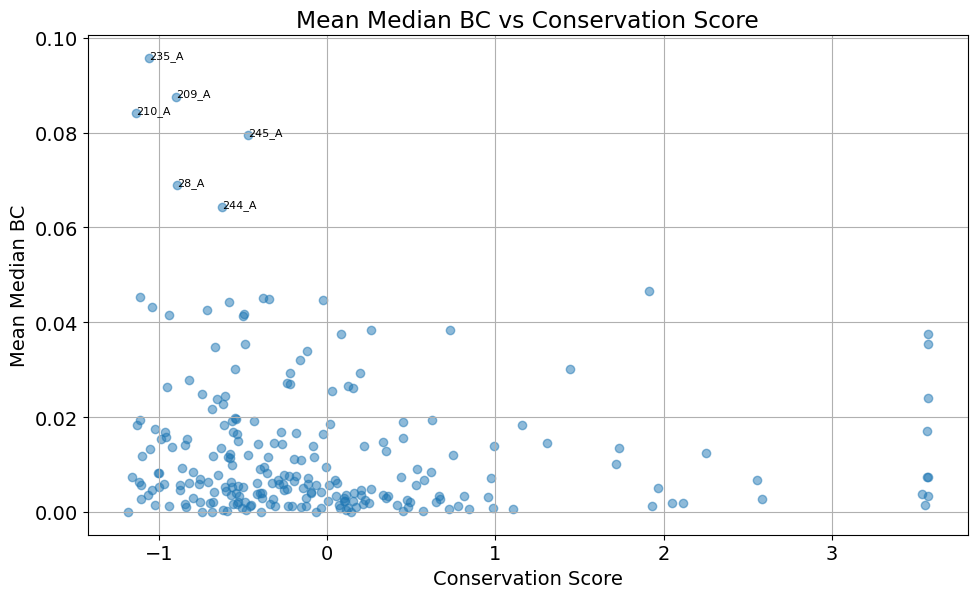

In [47]:
# Plot mean_median_bc vs cons_score
plt.figure(figsize=(10, 6))
# Increase font size to make it more readable
plt.rcParams.update({'font.size': 14})
plt.scatter(df_bc_sig_aff_resids[df_bc_sig_aff_resids['Residue_id'].str.contains('_A')]['cons_score'], 
            df_bc_sig_aff_resids[df_bc_sig_aff_resids['Residue_id'].str.contains('_A')]['mean_median_bc'], alpha=0.5)
plt.xlabel('Conservation Score')
plt.ylabel('Mean Median BC')
# Annotate the points with their residue IDs, but only for those with mean BC above 0.06
for i, row in df_bc_sig_aff_resids[df_bc_sig_aff_resids['Residue_id'].str.contains('_A')].iterrows():
    if row['mean_median_bc'] > 0.06:
        plt.annotate(row['Residue_id'], (row['cons_score'], row['mean_median_bc']), fontsize=8)
plt.grid()
plt.tight_layout()
plt.title('Mean Median BC vs Conservation Score')

In [144]:
df_bc_sig_aff_resids.sort_values(by='diff_bc_3utq_pf',ascending=False, inplace=True)
top10_bc_aff_3utq = df_bc_sig_aff_resids[:10]
top10_bc_aff_3utq

Residue_id  mean_median_bc  diff_bc_3utq_pf  diff_bc_5n1y_pf  \
168       64_B        0.182151         0.043241         0.059742   
9         27_A        0.045115         0.042899        -0.084879   
4          5_A        0.027224         0.022111         0.002408   
188       31_A        0.044813         0.019177         0.006126   
295       33_B        0.016053         0.010388         0.010595   
181      100_B        0.024045         0.010350         0.026399   
127      244_A        0.064223         0.010104        -0.077239   
179       96_B        0.044205         0.008857         0.000263   
38       101_A        0.006282         0.007803        -0.008318   
240       63_B        0.073151         0.007379         0.000970   

     diff_bc_5c0f_pf  pt_diff_bc_3utq_pf  pt_diff_bc_5n1y_pf  \
168         0.022860            0.235720            0.298793   
9          -0.083871            0.330082          -38.814617   
4          -0.005756            0.513257            0.102988   
188         0.050432            0.494961            0.238414   
295        -0.001381            0.521828            0.526765   
181        -0.010081            0.405781            0.635288   
127        -0.072635            0.083562           -2.300558   
179         0.000309            0.177422            0.006368   
38         -0.008532            0.456300           -8.489691   
240        -0.002196            0.094030            0.013453   

     pt_diff_bc_5c0f_pf  
168            0.140190  
9            -26.252718  
4             -0.378357  
188            0.720460  
295           -0.169710  
181           -1.986790  
127           -1.902544  
179            0.007473  
38           -11.134383  
240           -0.031865

In [156]:
df_bc_sig_aff_resids.sort_values(by='diff_bc_5n1y_pf',ascending=False, inplace=True)
top10_bc_aff_5n1y = df_bc_sig_aff_resids[:10]
top10_bc_aff_5n1y

Residue_id  mean_median_bc  diff_bc_3utq_pf  diff_bc_5n1y_pf  \
223      210_A        0.084164         0.000264         0.128271   
119      235_A        0.095692        -0.004055         0.103902   
268      245_A        0.079498         0.001159         0.098618   
168       64_B        0.182151         0.043241         0.059742   
10        28_A        0.068979         0.004103         0.059413   
95       203_A        0.045367        -0.004684         0.057570   
189       32_A        0.044777        -0.000578         0.050250   
96       205_A        0.041625         0.001207         0.046358   
46       117_A        0.041397        -0.002830         0.042116   
291      182_A        0.031988        -0.000317         0.040536   

     diff_bc_5c0f_pf  pt_diff_bc_3utq_pf  pt_diff_bc_5n1y_pf  \
223         0.108277            0.048076            0.960848   
119         0.121644           -0.227730            0.826167   
268         0.110985            0.111395            0.914298   
168         0.022860            0.235720            0.298793   
10          0.061673            0.130874            0.685571   
95          0.048539           -0.681355            0.832800   
189         0.038411           -0.038968            0.765239   
96          0.049254            0.114347            0.832134   
46          0.047082           -0.289407            0.769614   
291         0.041116           -0.069486            0.892608   

     pt_diff_bc_5c0f_pf        p_value  
223            0.953952  1.294084e-291  
119            0.847658  2.249479e-139  
268            0.923114  1.453574e-167  
168            0.140190   6.132575e-32  
10             0.693562   6.786716e-97  
95             0.807672  2.304552e-177  
189            0.713605   4.637470e-57  
96             0.840429  2.603455e-129  
46             0.788780  1.333285e-203  
291            0.893962  1.567167e-158

In [157]:
df_bc_sig_aff_resids.sort_values(by='diff_bc_5c0f_pf',ascending=False, inplace=True)
top10_bc_aff_5c0f = df_bc_sig_aff_resids[:10]
top10_bc_aff_5c0f

Residue_id  mean_median_bc  diff_bc_3utq_pf  diff_bc_5n1y_pf  \
119      235_A        0.095692        -0.004055         0.103902   
268      245_A        0.079498         0.001159         0.098618   
223      210_A        0.084164         0.000264         0.128271   
10        28_A        0.068979         0.004103         0.059413   
188       31_A        0.044813         0.019177         0.006126   
96       205_A        0.041625         0.001207         0.046358   
95       203_A        0.045367        -0.004684         0.057570   
289      100_A        0.027915        -0.000890         0.032790   
46       117_A        0.041397        -0.002830         0.042116   
7         24_A        0.030123         0.001012         0.035969   

     diff_bc_5c0f_pf  pt_diff_bc_3utq_pf  pt_diff_bc_5n1y_pf  \
119         0.121644           -0.227730            0.826167   
268         0.110985            0.111395            0.914298   
223         0.108277            0.048076            0.960848   
10          0.061673            0.130874            0.685571   
188         0.050432            0.494961            0.238414   
96          0.049254            0.114347            0.832134   
95          0.048539           -0.681355            0.832800   
289         0.047324           -1.443928            0.956055   
46          0.047082           -0.289407            0.769614   
7           0.041724            0.206439            0.902442   

     pt_diff_bc_5c0f_pf        p_value  
119            0.847658  2.249479e-139  
268            0.923114  1.453574e-167  
223            0.953952  1.294084e-291  
10             0.693562   6.786716e-97  
188            0.720460   1.989408e-24  
96             0.840429  2.603455e-129  
95             0.807672  2.304552e-177  
289            0.969135  3.836451e-280  
46             0.788780  1.333285e-203  
7              0.914752  7.859775e-191

<Axes: xlabel='Residue_id', ylabel='BC'>

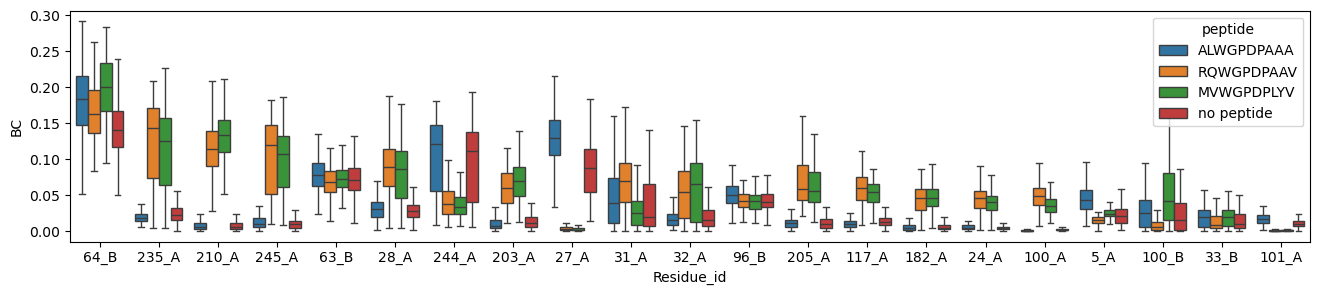

In [147]:
top10_bc = pd.concat([top10_bc_aff_3utq, top10_bc_aff_5n1y, top10_bc_aff_5c0f],ignore_index=True)
top10_bc.sort_values(by='mean_median_bc',ascending=False,inplace=True)
(fig,ax) = plt.subplots(nrows=1,ncols=1,figsize=(16,3))
df_2plot = df_bc_equil_cons_resids[df_bc_equil_cons_resids['Residue_id'].isin(top10_bc['Residue_id'].values)]
order = top10_bc['Residue_id'].values
sns.boxplot(df_2plot,x='Residue_id',y='BC',hue='peptide', ax= ax, order=order,showfliers=False)

In [158]:
df_bc_sig_aff_resids.sort_values(by='diff_bc_3utq_pf',ascending=True, inplace=True)
bottom10_bc_aff_3utq = df_bc_sig_aff_resids[:10]
bottom10_bc_aff_3utq

Residue_id  mean_median_bc  diff_bc_3utq_pf  diff_bc_5n1y_pf  \
5          7_A        0.029238        -0.022486        -0.017965   
118      234_A        0.042674        -0.019224        -0.138788   
183        9_A        0.017138        -0.017076        -0.035268   
166       61_B        0.077686        -0.012083        -0.010938   
164       54_B        0.025517        -0.011748        -0.009962   
267      241_A        0.026270        -0.010883        -0.058888   
169       65_B        0.093996        -0.010212        -0.008092   
215      181_A        0.024823        -0.010187        -0.029974   
280       12_A        0.005535        -0.010150        -0.005590   
11        30_A        0.030209        -0.009989        -0.054517   

     diff_bc_5c0f_pf  pt_diff_bc_3utq_pf  pt_diff_bc_5n1y_pf  \
5           0.018430           -1.595672           -0.965128   
118        -0.137505           -0.157633          -58.042910   
183        -0.027410           -0.640816           -4.171687   
166        -0.007134           -0.159712           -0.142418   
164        -0.012744           -0.465179           -0.368414   
267        -0.059306           -0.186311           -5.658480   
169        -0.007747           -0.110441           -0.085546   
215        -0.033263           -0.260477           -1.551116   
280        -0.008769           -2.856027           -0.688819   
11         -0.061296           -0.160714           -3.093002   

     pt_diff_bc_5c0f_pf        p_value  
5              0.335043   2.696754e-78  
118          -37.421373  2.583621e-194  
183           -1.680275  1.053465e-151  
166           -0.088509   7.149962e-07  
164           -0.525365   6.294000e-11  
267           -5.937006  1.745512e-145  
169           -0.081610   3.653714e-03  
215           -2.074354   2.224194e-58  
280           -1.776852   1.517493e-64  
11            -5.651142   7.917171e-54

In [159]:
df_bc_sig_aff_resids.sort_values(by='diff_bc_5n1y_pf',ascending=True, inplace=True)
bottom10_bc_aff_5n1y = df_bc_sig_aff_resids[:10]
bottom10_bc_aff_5n1y

Residue_id  mean_median_bc  diff_bc_3utq_pf  diff_bc_5n1y_pf  \
118      234_A        0.042674        -0.019224        -0.138788   
9         27_A        0.045115         0.042899        -0.084879   
127      244_A        0.064223         0.010104        -0.077239   
267      241_A        0.026270        -0.010883        -0.058888   
11        30_A        0.030209        -0.009989        -0.054517   
203      113_A        0.016380        -0.002471        -0.046473   
258      116_A        0.035460         0.002892        -0.040834   
221      202_A        0.044307         0.000628        -0.035935   
183        9_A        0.017138        -0.017076        -0.035268   
246       25_A        0.013464        -0.008608        -0.035165   

     diff_bc_5c0f_pf  pt_diff_bc_3utq_pf  pt_diff_bc_5n1y_pf  \
118        -0.137505           -0.157633          -58.042910   
9          -0.083871            0.330082          -38.814617   
127        -0.072635            0.083562           -2.300558   
267        -0.059306           -0.186311           -5.658480   
11         -0.061296           -0.160714           -3.093002   
203        -0.045376           -0.054495          -34.489505   
258        -0.035054            0.046139           -2.153871   
221        -0.033668            0.009247           -1.145741   
183        -0.027410           -0.640816           -4.171687   
246        -0.033938           -0.279847           -8.365856   

     pt_diff_bc_5c0f_pf        p_value  
118          -37.421373  2.583621e-194  
9            -26.252718  4.713842e-269  
127           -1.902544   3.042446e-70  
267           -5.937006  1.745512e-145  
11            -5.651142   7.917171e-54  
203          -18.569864  8.292409e-307  
258           -1.416991  4.995425e-114  
221           -1.001142   4.169669e-89  
183           -1.680275  1.053465e-151  
246           -6.250006  1.498076e-182

In [160]:
df_bc_sig_aff_resids.sort_values(by='diff_bc_5c0f_pf',ascending=True, inplace=True)
bottom10_bc_aff_5c0f = df_bc_sig_aff_resids[:10]
bottom10_bc_aff_5c0f

Residue_id  mean_median_bc  diff_bc_3utq_pf  diff_bc_5n1y_pf  \
118      234_A        0.042674        -0.019224        -0.138788   
9         27_A        0.045115         0.042899        -0.084879   
127      244_A        0.064223         0.010104        -0.077239   
11        30_A        0.030209        -0.009989        -0.054517   
267      241_A        0.026270        -0.010883        -0.058888   
203      113_A        0.016380        -0.002471        -0.046473   
258      116_A        0.035460         0.002892        -0.040834   
213      179_A        0.015347        -0.005303        -0.033036   
246       25_A        0.013464        -0.008608        -0.035165   
221      202_A        0.044307         0.000628        -0.035935   

     diff_bc_5c0f_pf  pt_diff_bc_3utq_pf  pt_diff_bc_5n1y_pf  \
118        -0.137505           -0.157633          -58.042910   
9          -0.083871            0.330082          -38.814617   
127        -0.072635            0.083562           -2.300558   
11         -0.061296           -0.160714           -3.093002   
267        -0.059306           -0.186311           -5.658480   
203        -0.045376           -0.054495          -34.489505   
258        -0.035054            0.046139           -2.153871   
213        -0.034110           -0.155085           -5.113273   
246        -0.033938           -0.279847           -8.365856   
221        -0.033668            0.009247           -1.145741   

     pt_diff_bc_5c0f_pf        p_value  
118          -37.421373  2.583621e-194  
9            -26.252718  4.713842e-269  
127           -1.902544   3.042446e-70  
11            -5.651142   7.917171e-54  
267           -5.937006  1.745512e-145  
203          -18.569864  8.292409e-307  
258           -1.416991  4.995425e-114  
213           -6.332365   5.893005e-93  
246           -6.250006  1.498076e-182  
221           -1.001142   4.169669e-89

<Axes: xlabel='Residue_id', ylabel='BC'>

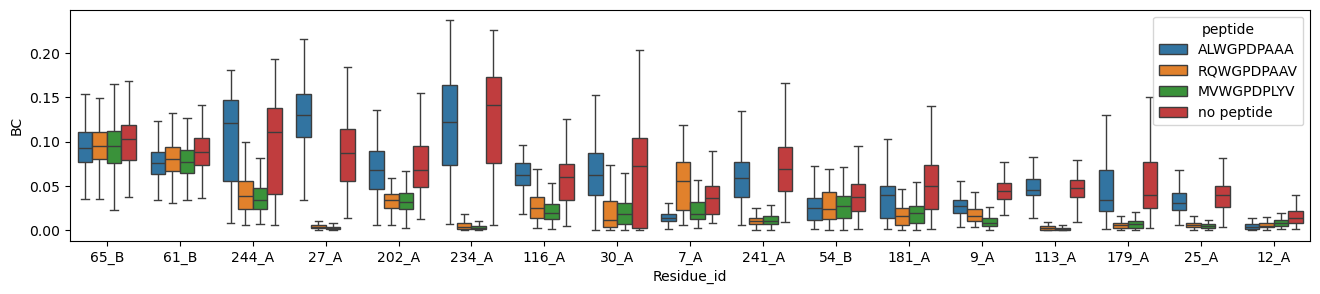

In [161]:
bottom10_bc = pd.concat([bottom10_bc_aff_3utq, bottom10_bc_aff_5n1y, bottom10_bc_aff_5c0f],ignore_index=True)
bottom10_bc.sort_values(by='mean_median_bc',ascending=False,inplace=True)
(fig,ax) = plt.subplots(nrows=1,ncols=1,figsize=(16,3))
df_2plot = df_bc_equil_cons_resids[df_bc_equil_cons_resids['Residue_id'].isin(bottom10_bc['Residue_id'].values)]
order = bottom10_bc['Residue_id'].values
sns.boxplot(df_2plot,x='Residue_id',y='BC',hue='peptide', ax= ax, order=order,showfliers=False)